In [11]:
import sys
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pylab as plt
import sys, os
sys.path.append(r'C:\Users\vhbncm\Desktop\3학년1학기 공부\밑바닥딥러닝\deep-learning-from-scratch-2-master\deep-learning-from-scratch-2-master') # 부모 디렉토리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist
import numpy as np
from PIL import Image
from common.functions import softmax, cross_entropy_error # common/functions.py에 정의한 softmax, cross_entropy_error 메서드를 이용 
from common.gradient import numerical_gradient
from common.functions import *
from common.gradient import numerical_gradient
from common.util import preprocess, create_contexts_target, convert_one_hot, im2col 
from common.layers import MatMul, SoftmaxWithLoss
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word


In [5]:
def create_contexts_target(corpus, window_size = 1):
    target = corpus[window_size: -window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + 1])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)
#단어 id의 배열(corpus), 윈도우 크기를 받아서 맥락과 타깃을 넘파이 배열로 반환
#말뭉치 (corpus)-> 맥락, 타겟을 만듬


In [6]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot



In [7]:
###CBOW 학습 데이터 준비
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)



In [8]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        #가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') #데이터 타입을 32비트 부동소수점 수로 초기화한다.
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        #계층 생성
        #입력측의 MatMul의 수는 단어의 수(윈도우의 크기)만큼 만들어야 한다. 
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        #모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params #매개변수
            self.grads += layer.grads #기울기 -> 리스트에 모아둔다. 
        
        #인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    #contexts는 3차원 넘파이 배열이라고 가정 
    #만약 (6, 2, 7)의 형상이라면 0번째 차원의 수는 미니배치의 수만큼 1번째 차원의 수는 맥락의 윈도우 크기(각 target마다의 맥락의 수) 
    #2번째 차원의 수는 원핫벡터 이다.
    
    def backward(self, dout = 1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
    

| 에폭 1 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 2 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 3 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 4 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 5 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 6 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 7 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 8 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 9 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 10 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 11 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 12 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 13 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 14 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 15 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 16 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 17 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 18 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 19 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 20 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 21 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 22 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 23 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 24 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 25 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 26 |

| 에폭 335 |  반복 1 / 1 | 시간 0[s] | 손실 1.23
| 에폭 336 |  반복 1 / 1 | 시간 0[s] | 손실 1.13
| 에폭 337 |  반복 1 / 1 | 시간 0[s] | 손실 1.30
| 에폭 338 |  반복 1 / 1 | 시간 0[s] | 손실 1.19
| 에폭 339 |  반복 1 / 1 | 시간 0[s] | 손실 1.12
| 에폭 340 |  반복 1 / 1 | 시간 0[s] | 손실 1.29
| 에폭 341 |  반복 1 / 1 | 시간 0[s] | 손실 1.11
| 에폭 342 |  반복 1 / 1 | 시간 0[s] | 손실 1.19
| 에폭 343 |  반복 1 / 1 | 시간 0[s] | 손실 1.17
| 에폭 344 |  반복 1 / 1 | 시간 0[s] | 손실 1.17
| 에폭 345 |  반복 1 / 1 | 시간 0[s] | 손실 1.28
| 에폭 346 |  반복 1 / 1 | 시간 0[s] | 손실 1.21
| 에폭 347 |  반복 1 / 1 | 시간 0[s] | 손실 1.19
| 에폭 348 |  반복 1 / 1 | 시간 0[s] | 손실 1.16
| 에폭 349 |  반복 1 / 1 | 시간 0[s] | 손실 1.09
| 에폭 350 |  반복 1 / 1 | 시간 0[s] | 손실 1.06
| 에폭 351 |  반복 1 / 1 | 시간 0[s] | 손실 1.20
| 에폭 352 |  반복 1 / 1 | 시간 0[s] | 손실 1.09
| 에폭 353 |  반복 1 / 1 | 시간 0[s] | 손실 1.05
| 에폭 354 |  반복 1 / 1 | 시간 0[s] | 손실 1.17
| 에폭 355 |  반복 1 / 1 | 시간 0[s] | 손실 1.15
| 에폭 356 |  반복 1 / 1 | 시간 0[s] | 손실 1.14
| 에폭 357 |  반복 1 / 1 | 시간 0[s] | 손실 1.26
| 에폭 358 |  반복 1 / 1 | 시간 0[s] | 손실 1.04
| 에폭 359 |  반복 1

| 에폭 704 |  반복 1 / 1 | 시간 0[s] | 손실 0.73
| 에폭 705 |  반복 1 / 1 | 시간 0[s] | 손실 0.56
| 에폭 706 |  반복 1 / 1 | 시간 0[s] | 손실 0.88
| 에폭 707 |  반복 1 / 1 | 시간 0[s] | 손실 0.55
| 에폭 708 |  반복 1 / 1 | 시간 0[s] | 손실 0.55
| 에폭 709 |  반복 1 / 1 | 시간 0[s] | 손실 0.55
| 에폭 710 |  반복 1 / 1 | 시간 0[s] | 손실 0.73
| 에폭 711 |  반복 1 / 1 | 시간 0[s] | 손실 0.96
| 에폭 712 |  반복 1 / 1 | 시간 0[s] | 손실 0.70
| 에폭 713 |  반복 1 / 1 | 시간 0[s] | 손실 0.96
| 에폭 714 |  반복 1 / 1 | 시간 0[s] | 손실 0.55
| 에폭 715 |  반복 1 / 1 | 시간 0[s] | 손실 0.89
| 에폭 716 |  반복 1 / 1 | 시간 0[s] | 손실 0.71
| 에폭 717 |  반복 1 / 1 | 시간 0[s] | 손실 0.80
| 에폭 718 |  반복 1 / 1 | 시간 0[s] | 손실 0.54
| 에폭 719 |  반복 1 / 1 | 시간 0[s] | 손실 0.70
| 에폭 720 |  반복 1 / 1 | 시간 0[s] | 손실 0.80
| 에폭 721 |  반복 1 / 1 | 시간 0[s] | 손실 0.80
| 에폭 722 |  반복 1 / 1 | 시간 0[s] | 손실 0.80
| 에폭 723 |  반복 1 / 1 | 시간 0[s] | 손실 0.89
| 에폭 724 |  반복 1 / 1 | 시간 0[s] | 손실 0.70
| 에폭 725 |  반복 1 / 1 | 시간 0[s] | 손실 0.54
| 에폭 726 |  반복 1 / 1 | 시간 0[s] | 손실 0.72
| 에폭 727 |  반복 1 / 1 | 시간 0[s] | 손실 0.88
| 에폭 728 |  반복 1

C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


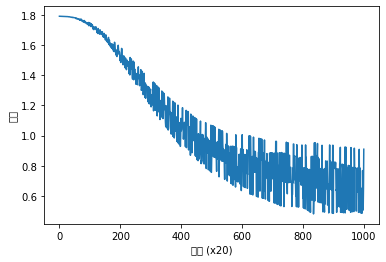

you [-0.87540793  0.80016583  0.80896044  0.92504704 -0.79494995]
say [-0.7925768  -0.87987864 -0.9021727   0.89108753  0.9010623 ]
goodbye [-0.6144647   0.8026468   0.752639    0.42998487 -0.776857  ]
and [-0.7911982  -0.88479054 -0.8903276   0.9171157   0.8995643 ]
i [-0.62771845  0.78963935  0.7452851   0.40906638 -0.7878715 ]
hello [-0.8232537   0.7727383   0.79019433  0.8955991  -0.78831476]


In [13]:
#CBOW 학습 코드 구현

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

#word_vecs = 단어의 분산표현 = 각 단어의 가중치


